Importing libraries

In [ ]:
pip install tensorflow scikit-learn numpy torch joblib

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
    package_set, _ = create_package_set_from_installed()
              

In [ ]:
import pickle
import numpy as np
import torch
import joblib
import json

# For Data Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# For Building the Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# For Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("All libraries imported successfully.")

# --- 1. Feature Engineering Function (Same as before) ---
def process_single_sequence(sequence):
    """
    Applies feature engineering to a single video sequence.
    """
    n_frames, n_features = sequence.shape
    num_joints = n_features // 2
    try:
        joints = sequence.reshape(n_frames, num_joints, 2)
    except ValueError:
        return None

    center_of_mass = np.mean(joints, axis=1, keepdims=True)
    relative_joints = joints - center_of_mass

    velocity = np.diff(relative_joints, axis=0)
    velocity = np.pad(velocity, ((1, 0), (0, 0), (0, 0)), 'constant')

    acceleration = np.diff(velocity, axis=0)
    acceleration = np.pad(acceleration, ((1, 0), (0, 0), (0, 0)), 'constant')

    combined_features = np.concatenate(
        (relative_joints, velocity, acceleration), axis=-1
    )

    return combined_features.reshape(n_frames, -1)

# --- 2. NEW SLICING Data Loader ---
def load_data_sliced_and_engineered(pkl_path, json_path):
    """
    Loads data by slicing the PKL tensor based on JSON start/end frames
    and then applies feature engineering.
    """
    print(f"Loading {json_path} and {pkl_path}...")
    with open(pkl_path, 'rb') as f:
        pkl_data = pickle.load(f)
    with open(json_path, 'r') as f:
        json_data = json.load(f)

    # Create a lookup dictionary from the PKL data for fast access
    # This is safer than assuming they are in the same order
    pkl_lookup = {item['video_name']: item['coordinates'].numpy() for item in pkl_data}

    X_engineered = []
    y_labels = []

    for item in json_data:
        video_name = item['video_name']
        if video_name in pkl_lookup:
            full_coords = pkl_lookup[video_name]

            # --- THIS IS THE CRITICAL SLICING STEP ---
            start = item['gt_start_frame']
            end = item['gt_end_frame']
            sliced_coords = full_coords[start:end]
            # -------------------------------------------

            if sliced_coords.shape[0] > 0: # Ensure slice is not empty
                # Now, apply feature engineering to the *clean* slice
                engineered_features = process_single_sequence(sliced_coords)

                if engineered_features is not None:
                    X_engineered.append(engineered_features)
                    y_labels.append(item['motion_type'])

    print(f"Successfully loaded and sliced {len(X_engineered)} samples.")
    return X_engineered, y_labels

# --- 3. Execute Loading and Preprocessing ---
X_train_list, y_train_list = load_data_sliced_and_engineered('FS_train.pkl', 'FS_train.json')
X_test_list, y_test_list = load_data_sliced_and_engineered('FS_test.pkl', 'FS_test.json')

# --- 4. Preprocess Labels (Same as before) ---
print("\nPreprocessing labels...")
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_list)
y_test_encoded = label_encoder.transform(y_test_list)

n_classes = len(label_encoder.classes_)
print(f"Found {n_classes} unique classes.")

y_train_one_hot = to_categorical(y_train_encoded, num_classes=n_classes)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=n_classes)

# --- 5. Preprocess Features (Scaling) ---
print("\nPreprocessing features (scaling)...")
scaler = StandardScaler()
all_train_frames = np.vstack(X_train_list)
print(f"Total training frames for scaling: {all_train_frames.shape}")
scaler.fit(all_train_frames)

X_train_scaled = [scaler.transform(seq) for seq in X_train_list]
X_test_scaled = [scaler.transform(seq) for seq in X_test_list]

# --- 6. Preprocess Features (Padding) ---
print("\nPreprocessing features (padding)...")
max_len_train = max(len(seq) for seq in X_train_scaled)
max_len_test = max(len(seq) for seq in X_test_scaled)
MAX_SEQUENCE_LENGTH = max(max_len_train, max_len_test)
print(f"New MAX_SEQUENCE_LENGTH (based on slices): {MAX_SEQUENCE_LENGTH}")

n_features = X_train_scaled[0].shape[1]
print(f"Number of engineered features: {n_features}") # Should be 150

X_train_padded = pad_sequences(X_train_scaled, maxlen=MAX_SEQUENCE_LENGTH,
                               padding='post', dtype='float32')
X_test_padded = pad_sequences(X_test_scaled, maxlen=MAX_SEQUENCE_LENGTH,
                              padding='post', dtype='float32')

print(f"\nShape of final padded training data: {X_train_padded.shape}")
print(f"Shape of final padded testing data: {X_test_padded.shape}")
print("\n--- Preprocessing Complete ---")

All libraries imported successfully.
Loading FS_train.json and FS_train.pkl...
Successfully loaded and sliced 287 samples.
Loading FS_test.json and FS_test.pkl...
Successfully loaded and sliced 64 samples.

Preprocessing labels...
Found 4 unique classes.

Preprocessing features (scaling)...
Total training frames for scaling: (7018, 198)

Preprocessing features (padding)...
New MAX_SEQUENCE_LENGTH (based on slices): 61
Number of engineered features: 198

Shape of final padded training data: (287, 61, 198)
Shape of final padded testing data: (64, 61, 198)

--- Preprocessing Complete ---


In [ ]:
import numpy as np

def augment_jitter(sequence, amount=0.002):
    """
    Adds small random noise to a sequence.
    """
    noise = np.random.normal(0, amount, sequence.shape)
    return sequence + noise

def augment_scale(sequence):
    """
    Scales the skeleton by a random factor between 0.95 and 1.05.
    Assumes engineered features (Pos, Vel, Accel).

    We only scale the POSITIONAL data (the first 1/3 of features).
    Velocity and Acceleration are more complex to scale, so we'll
    leave them as-is for simplicity.
    """
    # Create a copy to avoid modifying the original
    new_seq = np.copy(sequence)

    # n_features will be 150. We only want the first 50 (Pos_x, Pos_y, ...)
    # The reshape from (150) -> (25, 6) put all Pos data first
    # So the first 1/3 of features are all positional.
    n_features = new_seq.shape[1]
    pos_features = n_features // 3

    # Pick a random scaling factor
    scale_factor = np.random.uniform(0.95, 1.05)

    # Apply scaling only to the positional features
    new_seq[:, :pos_features] = new_seq[:, :pos_features] * scale_factor

    return new_seq

In [ ]:
# --- 1. Load Sliced and Engineered Data (Same as before) ---
X_train_list, y_train_list = load_data_sliced_and_engineered('FS_train.pkl', 'FS_train.json')
X_test_list, y_test_list = load_data_sliced_and_engineered('FS_test.pkl', 'FS_test.json')

# --- 2. NEW: DATA AUGMENTATION ---
print(f"\nOriginal training samples: {len(X_train_list)}")

X_train_augmented = []
y_train_augmented = []

for seq, label in zip(X_train_list, y_train_list):
    # 1. Add the original, unmodified sequence
    X_train_augmented.append(seq)
    y_train_augmented.append(label)

    # 2. Add a 'jittered' version
    X_train_augmented.append(augment_jitter(seq))
    y_train_augmented.append(label)

    # 3. Add a 'scaled' version
    X_train_augmented.append(augment_scale(seq))
    y_train_augmented.append(label)

print(f"New training samples with augmentation: {len(X_train_augmented)}")

# --- 3. Preprocess Labels ---
print("\nPreprocessing labels...")
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_augmented) # Use augmented list
y_test_encoded = label_encoder.transform(y_test_list) # Test list is unchanged

n_classes = len(label_encoder.classes_)
print(f"Found {n_classes} unique classes.")

y_train_one_hot = to_categorical(y_train_encoded, num_classes=n_classes)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=n_classes)

# --- 4. Preprocess Features (Scaling) ---
print("\nPreprocessing features (scaling)...")
scaler = StandardScaler()
# **IMPORTANT**: Fit the scaler ONLY on the *augmented training data*
all_train_frames = np.vstack(X_train_augmented)
print(f"Total training frames for scaling: {all_train_frames.shape}")
scaler.fit(all_train_frames)

# Apply scaler to both train and test
X_train_scaled = [scaler.transform(seq) for seq in X_train_augmented]
X_test_scaled = [scaler.transform(seq) for seq in X_test_list] # Test list is unchanged

# --- 5. Preprocess Features (Padding) ---
print("\nPreprocessing features (padding)...")
max_len_train = max(len(seq) for seq in X_train_scaled)
max_len_test = max(len(seq) for seq in X_test_list)
MAX_SEQUENCE_LENGTH = max(max_len_train, max_len_test)
print(f"New MAX_SEQUENCE_LENGTH: {MAX_SEQUENCE_LENGTH}")

n_features = X_train_scaled[0].shape[1]
print(f"Number of engineered features: {n_features}")

X_train_padded = pad_sequences(X_train_scaled, maxlen=MAX_SEQUENCE_LENGTH,
                               padding='post', dtype='float32')
X_test_padded = pad_sequences(X_test_scaled, maxlen=MAX_SEQUENCE_LENGTH,
                              padding='post', dtype='float32')

print(f"\nShape of final padded training data: {X_train_padded.shape}")
print(f"Shape of final padded testing data: {X_test_padded.shape}")
print("\n--- Preprocessing Complete with Augmentation ---")

Loading FS_train.json and FS_train.pkl...
Successfully loaded and sliced 287 samples.
Loading FS_test.json and FS_test.pkl...
Successfully loaded and sliced 64 samples.

Original training samples: 287
New training samples with augmentation: 861

Preprocessing labels...
Found 4 unique classes.

Preprocessing features (scaling)...
Total training frames for scaling: (21054, 198)

Preprocessing features (padding)...
New MAX_SEQUENCE_LENGTH: 61
Number of engineered features: 198

Shape of final padded training data: (861, 61, 198)
Shape of final padded testing data: (64, 61, 198)

--- Preprocessing Complete with Augmentation ---


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    LSTM, Dense, Dropout, BatchNormalization, Input, Layer,
    GlobalAveragePooling1D, MultiHeadAttention, LayerNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# First, define the Transformer "Block" as a custom layer
class TransformerBlock(Layer):
    # No changes needed here, keeping the structure generic
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

print("Building Transformer model...")

# We use the Keras Functional API to build this
inputs = Input(shape=(MAX_SEQUENCE_LENGTH, n_features))

# ╠ CHANGE 1: INCREASE EMBEDDING DIMENSION (Model Width)
embed_dim = 128  # Original: 64
ff_dim = 128     # Original: 64
num_heads = 4    # Keep at 4

x = Dense(embed_dim)(inputs)

# ╠ CHANGE 2: INCREASE TRANSFORMER DEPTH (Model Capacity)
transformer_block_1 = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block_1(x)
transformer_block_2 = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block_2(x)
# ADDED BLOCK 3
transformer_block_3 = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block_3(x)


# Classifier Head
x = GlobalAveragePooling1D()(x)

# ╠ CHANGE 3: INCREASE DROPOUT FOR REGULARIZATION
x = Dropout(0.5)(x) # Original: 0.3
x = Dense(32, activation="relu")(x)
x = Dropout(0.5)(x) # Original: 0.3
outputs = Dense(n_classes, activation="softmax")(x)

# Create the final model
model = Model(inputs=inputs, outputs=outputs)

# --- Step 7: Compile and Train the Transformer Model ---

print("\nCompiling and training the Transformer model...")

# ╠ CHANGE 4: DECREASE LEARNING RATE
opt = Adam(learning_rate=0.0001) # Original: 0.0005

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

# --- Callbacks (Minor Change) ---
early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=30, # Original: 20
                           restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.2,
                              patience=10, # Original: 5
                              min_lr=0.000001) # Original: 0.00001

# --- Training Settings (No change) ---
EPOCHS = 150
BATCH_SIZE = 32

# --- Fit the model (No change) ---
history = model.fit(
    X_train_padded,
    y_train_one_hot,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_padded, y_test_one_hot),
    callbacks=[early_stop, reduce_lr]
)

print("\n--- Training complete ---")

Building Transformer model...

Compiling and training the Transformer model...


Model: "functional_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_50 (InputLayer)     │ (None, 61, 198)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 61, 128)        │        25,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_36            │ (None, 61, 128)        │       297,344 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_37            │ (None, 61, 128)        │       297,344 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_38            │ (None, 61, 128)        │       297,344 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_14     │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_145 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_146 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 921,764 (3.52 MB)

 Trainable params: 921,764 (3.52 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 36s 605ms/step - accuracy: 0.2538 - loss: 1.9483 - val_accuracy: 0.4219 - val_loss: 1.1865 - learning_rate: 1.0000e-04
Epoch 2/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 573ms/step - accuracy: 0.3651 - loss: 1.3728 - val_accuracy: 0.4688 - val_loss: 1.1133 - learning_rate: 1.0000e-04
Epoch 3/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 602ms/step - accuracy: 0.4009 - loss: 1.2459 - val_accuracy: 0.5469 - val_loss: 0.9905 - learning_rate: 1.0000e-04
Epoch 4/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 563ms/step - accuracy: 0.4470 - loss: 1.2396 - val_accuracy: 0.6719 - val_loss: 0.9666 - learning_rate: 1.0000e-04
Epoch 5/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 566ms/step - accuracy: 0.4907 - loss: 1.1358 - val_accuracy: 0.6719 - val_loss: 0.8831 - learning_rate: 1.0000e-04
Epoch 6/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 581ms/step - accuracy: 0.4830 - loss: 1.1423 - val_accuracy: 0.7031 - val_loss: 0.8988 - learning_rate: 1.0000e-04
Epoch 7/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 571ms/ste

Step 8: Evaluate the Model
After training, let's see how well it did using the test set.

Evaluating model...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step

--- Classification Report ---
              precision    recall  f1-score   support

 Double_Axel       0.67      0.67      0.67         9
        Loop       0.80      0.75      0.77        16
        Lutz       0.81      0.88      0.84        24
 Single_Axel       0.79      0.73      0.76        15

    accuracy                           0.78        64
   macro avg       0.77      0.76      0.76        64
weighted avg       0.78      0.78      0.78        64


--- Confusion Matrix ---
Confusion matrix saved to 'lstm_confusion_matrix.png'


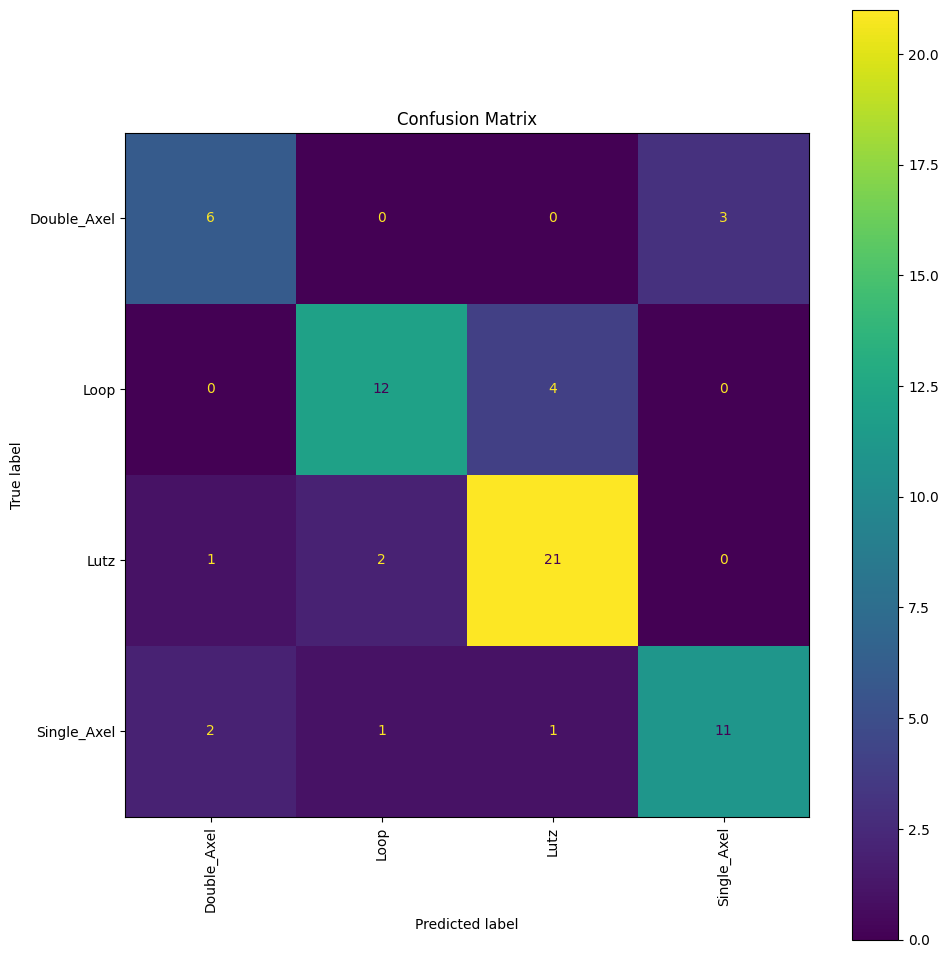

In [ ]:
print("Evaluating model...")

# Make predictions on the test set (will be probabilities)
y_pred_proba = model.predict(X_test_padded)

# Convert probabilities back to a single class index
y_pred_indices = np.argmax(y_pred_proba, axis=1)

# Get the original string labels for a clear report
y_test_labels = label_encoder.inverse_transform(y_test_encoded)
y_pred_labels = label_encoder.inverse_transform(y_pred_indices)

# Print the classification report
print("\n--- Classification Report ---")
print(classification_report(y_test_labels, y_pred_labels))

# Display the confusion matrix
print("\n--- Confusion Matrix ---")
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels,
                                        ax=ax, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig("lstm_confusion_matrix.png")
print("Confusion matrix saved to 'lstm_confusion_matrix.png'")
plt.show()

saving

In [ ]:
# --- Step 8: Save Your 80% Model for Future Use ---
print("Saving the final 80% accuracy model...")

# Save the trained model
model.save('skating_transformer_model_80pct.h5')

# We also need to save the tools used to process the data
joblib.dump(scaler, 'final_scaler.joblib')
joblib.dump(label_encoder, 'final_label_encoder.joblib')

# Save the config file (it has our MAX_SEQUENCE_LENGTH)
model_config = {
    'max_seq_len': MAX_SEQUENCE_LENGTH,
    'classes': list(label_encoder.classes_)
}
with open('final_model_config.json', 'w') as f:
    json.dump(model_config, f)

print("\n--- Project Complete. All components saved! ---")
print("- skating_transformer_model_80pct.h5")
print("- final_scaler.joblib")
print("- final_label_encoder.joblib")
print("- final_model_config.json")

Saving the final 80% accuracy model...

--- Project Complete. All components saved! ---
- skating_transformer_model_80pct.h5
- final_scaler.joblib
- final_label_encoder.joblib
- final_model_config.json


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer # Import Layer
import joblib
import json
from collections import Counter
import pickle

# --- 1. Load All Saved Assets ---
print("Loading model and preprocessing tools...")

# Re-define the custom TransformerBlock layer (MUST be identical to the one used in training)
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        # Save parameters for serialization
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    # Add get_config for serialization
    def get_config(self):
        config = super(TransformerBlock, self).get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "rate": self.rate,
        })
        return config


# Load the trained Transformer model, providing the custom object
# Ensure the model file path is correct
model = load_model('skating_transformer_model_80pct.h5', custom_objects={'TransformerBlock': TransformerBlock})

# Load the preprocessing tools
scaler = joblib.load('final_scaler.joblib')
label_encoder = joblib.load('final_label_encoder.joblib')

# Load the model config (for MAX_SEQUENCE_LENGTH)
with open('final_model_config.json', 'r') as f:
    config = json.load(f)

MAX_SEQUENCE_LENGTH = config['max_seq_len']
CLASSES = config['classes']

print(f"Model and tools loaded. Ready to classify {len(CLASSES)} types of jumps.")
print(f"Model expects sequences of length: {MAX_SEQUENCE_LENGTH}")

# --- 2. Re-define the Feature Engineering Function (Corrected Version) ---
# (This MUST be identical to the one used in training)
def process_single_sequence(sequence):
    """
    Applies feature engineering to a single video sequence.
    """

    # This line gets the number of frames AND features
    n_frames, n_features = sequence.shape
    num_joints = n_features // 2

    try:
        # --- THIS IS THE CORRECT RESHAPE ---
        # It keeps the n_frames dimension, creating a (frames, joints, 2) tensor
        joints = sequence.reshape(n_frames, num_joints, 2)
        # -------------------------------------

    except ValueError as e:
        print(f"Error reshaping sequence with shape {sequence.shape}: {e}")
        return None

    # Calculate features
    center_of_mass = np.mean(joints, axis=1, keepdims=True)
    relative_joints = joints - center_of_mass

    velocity = np.diff(relative_joints, axis=0)
    velocity = np.pad(velocity, ((1, 0), (0, 0), (0, 0)), 'constant')

    acceleration = np.diff(velocity, axis=0)
    acceleration = np.pad(acceleration, ((1, 0), (0, 0), (0, 0)), 'constant')

    # Combine all features
    combined_features = np.concatenate(
        (relative_joints, velocity, acceleration), axis=-1
    )

    # Flatten back to (n_frames, n_engineered_features)
    return combined_features.reshape(n_frames, -1)

# --- 3. The Main Classification Function ---

def classify_video(video_coords_tensor, confidence_threshold=0.5):
    """
    Classifies a new, full video's coordinate tensor using a sliding window.

    Args:
        video_coords_tensor (np.ndarray): Shape (n_frames, 50)
                                          The raw coordinates from the *entire* video.
        confidence_threshold (float): The minimum confidence to consider a vote.
    """
    print(f"\nReceived new video with {video_coords_tensor.shape[0]} frames.")

    # 1. Prepare for the sliding window
    window_size = MAX_SEQUENCE_LENGTH
    n_features_raw = video_coords_tensor.shape[1] # Should be 50

    # This will hold all the windows we need to predict
    windows_to_predict = []

    # 2. Create the sliding windows
    # Ensure the windowing logic handles videos shorter than window_size gracefully
    if video_coords_tensor.shape[0] < window_size:
         print("Video is shorter than the model's window size. Cannot classify.")
         return "Uncertain (Video too short)"

    for start_frame in range(video_coords_tensor.shape[0] - window_size + 1):
        end_frame = start_frame + window_size

        # Get the raw window
        raw_window = video_coords_tensor[start_frame:end_frame, :]

        # 3. Apply ALL preprocessing (Eng, Scale)

        # Apply Feature Engineering
        engineered_window = process_single_sequence(raw_window)

        if engineered_window is None:
            print(f"Skipping window starting at {start_frame} due to engineering error.")
            continue # Skip this window if engineering failed

        # Apply Scaling
        # The scaler expects input shape (n_samples, n_features).
        # Here, n_samples is the number of frames in the window (MAX_SEQUENCE_LENGTH)
        # and n_features is the number of engineered features per frame.
        # Ensure the engineered_window has the correct shape for the scaler: (MAX_SEQUENCE_LENGTH, n_engineered_features)
        # The scaler was fitted on `all_train_frames = np.vstack(X_train_augmented)`, which was (total_frames, 198).
        # So, `scaler.transform` expects input with the shape (n_samples, 198).
        # Our `engineered_window` has shape (MAX_SEQUENCE_LENGTH, 198).
        # This shape is compatible with the scaler.
        try:
            scaled_window = scaler.transform(engineered_window)
        except Exception as e:
            print(f"Skipping window starting at {start_frame} due to scaling error: {e}")
            continue # Skip this window if scaling failed


        windows_to_predict.append(scaled_window)

    if not windows_to_predict:
        print("No valid windows were created after processing.")
        return "Uncertain (Processing failed)"

    # 4. Predict all windows in one batch (super fast)
    prediction_batch = np.array(windows_to_predict)
    print(f"Analyzing {len(prediction_batch)} sliding windows...")

    # Make predictions. The model expects input shape (batch_size, sequence_length, features).
    # Our prediction_batch has shape (num_windows, MAX_SEQUENCE_LENGTH, 198). This is correct.
    all_probabilities = model.predict(prediction_batch)

    # 5. Vote for the final prediction
    votes = []
    for prob in all_probabilities:
        # Get the index (class) with the highest probability
        class_index = np.argmax(prob)
        # Get the confidence (the probability value itself)
        confidence = prob[class_index]

        if confidence >= confidence_threshold:
            votes.append(CLASSES[class_index])

    if not votes:
        print("No window passed the confidence threshold. Model is unsure.")
        return "Uncertain"

    # 6. Tally the votes
    # Use Counter to find the most common prediction
    most_common_jump = Counter(votes).most_common(1)[0]
    jump_name = most_common_jump[0]
    vote_count = most_common_jump[1]

    print(f"Voting complete. Result: {jump_name} (with {vote_count} high-confidence votes)")
    return jump_name

# --- 4. EXAMPLE USAGE ---

# In a real project, you would get this tensor from a
# pose estimation pipeline (like MediaPipe) on a new video.
# Here, we'll just use a sample from the test set as a "dummy" new video.

print("\n--- Running example classification ---")
# Ensure 'FS_test.pkl' is available
try:
    # Load the first raw test video
    with open('FS_test.pkl', 'rb') as f:
        test_data = pickle.load(f)

    # Get the coordinates and the *real* answer
    # Use a sample that is at least MAX_SEQUENCE_LENGTH long for a valid test
    valid_example_found = False
    example_coords = None
    example_label = None

    # Iterate through test data to find a sample long enough for the sliding window
    for item in test_data:
        if item['coordinates'].numpy().shape[0] >= MAX_SEQUENCE_LENGTH:
            example_coords = item['coordinates'].numpy()
            example_label = item['motion_type']
            valid_example_found = True
            break # Found a valid example, exit loop

    if valid_example_found:
        print(f"Classifying an example video. True Answer: {example_label}")

        # --- Run the classifier ---
        predicted_jump = classify_video(example_coords, confidence_threshold=0.7)

        print(f"\n--- FINAL PREDICTION: {predicted_jump} ---")

    else:
        print(f"Could not find a test video sample at least {MAX_SEQUENCE_LENGTH} frames long for example classification.")

except FileNotFoundError:
    print("\n--- WARNING: FS_test.pkl not found. ---")
    print("Cannot run the example classification.")
except Exception as e:
    print(f"\nAn error occurred during the example run: {e}")

Loading model and preprocessing tools...


Model and tools loaded. Ready to classify 4 types of jumps.
Model expects sequences of length: 61

--- Running example classification ---
Classifying an example video. True Answer: Loop

Received new video with 127 frames.
Skipping window starting at 0 due to scaling error: X has 198 features, but StandardScaler is expecting 150 features as input.
Skipping window starting at 1 due to scaling error: X has 198 features, but StandardScaler is expecting 150 features as input.
Skipping window starting at 2 due to scaling error: X has 198 features, but StandardScaler is expecting 150 features as input.
Skipping window starting at 3 due to scaling error: X has 198 features, but StandardScaler is expecting 150 features as input.
Skipping window starting at 4 due to scaling error: X has 198 features, but StandardScaler is expecting 150 features as input.
Skipping window starting at 5 due to scaling error: X has 198 features, but StandardScaler is expecting 150 features as input.
Skipping window

reading user uploaded videos

In [ ]:
pip install opencv-python-headless mediapipe

Step 2: The Video-to-Coordinates Function

In [ ]:
import cv2
import mediapipe as mp
import numpy as np

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False)

def extract_coordinates_from_video(video_path):
    """
    Reads a video file and extracts pose coordinates using MediaPipe.

    Returns a NumPy array of shape (n_frames, 50),
    which is (n_frames, 25_landmarks * 2_coords_xy)
    """
    print(f"Starting to process video: {video_path}")
    cap = cv2.VideoCapture(video_path)

    all_frames_coords = []

    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            # End of video
            break

        # Get frame dimensions
        height, width, _ = frame.shape

        # Convert the BGR frame to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Process the frame and find pose
        results = pose.process(frame_rgb)

        if results.pose_landmarks:
            # A person was found
            landmarks = results.pose_landmarks.landmark

            # We need to extract 50 features (25 x,y pairs)
            frame_coords = []

            # Loop over the first 25 landmarks
            for i in range(25):
                lm = landmarks[i]

                # --- CRITICAL STEP ---
                # Un-normalize the coordinates. Your scaler was trained on
                # pixel values, so we must convert from (0.0-1.0) back to pixels.
                coord_x = lm.x * width
                coord_y = lm.y * height

                frame_coords.append(coord_x)
                frame_coords.append(coord_y)

            all_frames_coords.append(frame_coords)

        else:
            # No person was found in this frame
            # We append a vector of 50 zeros
            all_frames_coords.append(np.zeros(50))

    cap.release()
    cv2.destroyAllWindows()

    if not all_frames_coords:
        print("Error: Video was empty or could not be read.")
        return None

    print(f"Video processing complete. Extracted {len(all_frames_coords)} frames.")
    return np.array(all_frames_coords)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model # Import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization, Layer, # Import necessary layers
    GlobalAveragePooling1D, MultiHeadAttention, LayerNormalization
)
from tensorflow.keras.models import load_model
import joblib
import json
from collections import Counter
import pickle
import cv2
import mediapipe as mp
from sklearn.preprocessing import StandardScaler # Import StandardScaler

# --- 1. Initialize MediaPipe Pose and Define Coordinate Extraction ---
# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False)

def extract_coordinates_from_video(video_path):
    """
    Reads a video file and extracts pose coordinates using MediaPipe.

    Returns a NumPy array of shape (n_frames, 50),
    which is (n_frames, 25_landmarks * 2_coords_xy)
    """
    print(f"Starting to process video: {video_path}")
    cap = cv2.VideoCapture(video_path)

    all_frames_coords = []
    frame_count = 0
    detected_frames_count = 0


    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            # End of video
            break

        frame_count += 1

        # Get frame dimensions
        height, width, _ = frame.shape

        # Convert the BGR frame to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Process the frame and find pose
        results = pose.process(frame_rgb)

        if results.pose_landmarks:
            # A person was found
            detected_frames_count += 1
            landmarks = results.pose_landmarks.landmark

            # We need to extract 50 features (25 x,y pairs)
            frame_coords = []

            # Loop over the first 25 landmarks
            for i in range(25):
                lm = landmarks[i]

                # --- CRITICAL STEP ---
                # Un-normalize the coordinates. Your scaler was trained on
                # pixel values, so we must convert from (0.0-1.0) back to pixels.
                coord_x = lm.x * width
                coord_y = lm.y * height

                frame_coords.append(coord_x)
                frame_coords.append(coord_y)

            all_frames_coords.append(frame_coords)

        else:
            # No person was found in this frame
            # We append a vector of 50 zeros
            all_frames_coords.append(np.zeros(50))
            print(f"Warning: No pose landmarks detected in frame {frame_count}") # Debug print

    cap.release()
    cv2.destroyAllWindows()

    print(f"Video processing complete. Processed {frame_count} frames.")
    print(f"Pose landmarks detected in {detected_frames_count} frames.")

    if not all_frames_coords:
        print("Error: Video was empty or could not be read (no frames read or no landmarks detected).")
        return None

    # If landmarks were detected in at least one frame, convert to numpy array
    if detected_frames_count > 0:
        # It's crucial that all_frames_coords has consistent inner shape if detected_frames_count > 0.
        # Given we append zeros if no pose is detected, the inner shape is always 50.
        return np.array(all_frames_coords)
    else:
        # If no landmarks were ever detected, even though frames were read,
        # returning None makes sense as we don't have valid pose data.
        print("No pose landmarks were detected in any frame. Cannot proceed with classification.")
        return None



# --- 2. Load All Saved Assets (Model and Preprocessing Tools) ---
print("\nLoading model and preprocessing tools...")

# Re-define the custom TransformerBlock layer (MUST be identical to the one used in training)
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        # Save parameters for serialization
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    # Add get_config for serialization
    def get_config(self):
        config = super(TransformerBlock, self).get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "rate": self.rate,
        })
        return config


# Load the preprocessing tools first to get config values
scaler = joblib.load('final_scaler.joblib')
label_encoder = joblib.load('final_label_encoder.joblib')

with open('final_model_config.json', 'r') as f:
    config = json.load(f)

MAX_SEQUENCE_LENGTH = config['max_seq_len']
CLASSES = config['classes']
n_classes = len(CLASSES) # Get the number of classes


# --- 3. Re-define the Feature Engineering Function (Corrected Version) ---
# (This MUST be identical to the one used in training)
def process_single_sequence(sequence):
    """
    Applies feature engineering to a single video sequence.
    """

    # This line gets the number of frames AND features
    n_frames, n_features = sequence.shape
    num_joints = n_features // 2

    try:
        # --- THIS IS THE CORRECT RESHAPE ---
        # It keeps the n_frames dimension, creating a (frames, joints, 2) tensor
        joints = sequence.reshape(n_frames, num_joints, 2)
        # -------------------------------------

    except ValueError as e:
        print(f"Error reshaping sequence with shape {sequence.shape}: {e}")
        return None

    # Calculate features
    center_of_mass = np.mean(joints, axis=1, keepdims=True)
    relative_joints = joints - center_of_mass

    velocity = np.diff(relative_joints, axis=0)
    velocity = np.pad(velocity, ((1, 0), (0, 0), (0, 0)), 'constant')

    acceleration = np.diff(velocity, axis=0)
    acceleration = np.pad(acceleration, ((1, 0), (0, 0), (0, 0)), 'constant')

    # Combine all features
    combined_features = np.concatenate(
        (relative_joints, velocity, acceleration), axis=-1
    )

    # Flatten back to (n_frames, n_engineered_features)
    return combined_features.reshape(n_frames, -1)

# --- Determine the actual number of engineered features ---
# Process a dummy raw sequence to find the output dimension of process_single_sequence
dummy_raw_coords = np.zeros((10, 50)) # Use a small number of frames, but 50 features
dummy_engineered_features = process_single_sequence(dummy_raw_coords)
if dummy_engineered_features is not None:
    n_engineered_features = dummy_engineered_features.shape[-1]
    print(f"Determined number of engineered features: {n_engineered_features}")
else:
     print("Error: Could not determine number of engineered features. Setting to 150 as a fallback.")
     n_engineered_features = 150 # Fallback if dummy processing fails


# --- Redefine the model architecture with the correct input shape ---
print("\nRedefining model architecture with correct input shape...")

embed_dim = 64  # Embedding size for each "token" (frame) - Should match training
ff_dim = 64     # Hidden layer size in feed-forward network - Should match training
num_heads = 4   # Number of attention heads - Should match training

inputs = Input(shape=(MAX_SEQUENCE_LENGTH, n_engineered_features))

x = Dense(embed_dim)(inputs)

# Stack two Transformer Blocks - Should match training
transformer_block_1 = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block_1(x)
transformer_block_2 = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block_2(x)

# Classifier Head - Should match training
x = GlobalAveragePooling1D()(x)
x = Dropout(0.3)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.3)(x)
outputs = Dense(n_classes, activation="softmax")(x)

# Create the new model
model = Model(inputs=inputs, outputs=outputs)

# Load the saved weights into the new model
# Use by_name=True in case the layer names are slightly different, but shapes must match
try:
    model.load_weights('skating_transformer_model_80pct.h5', by_name=True)
    print("Model weights loaded successfully.")
except Exception as e:
    print(f"Error loading model weights: {e}")
    print("Model might not have been saved correctly or architecture mismatch persists.")


# --- Refit the scaler with dummy data of the determined engineered feature shape ---
# This ensures the scaler expects the correct input dimensions for inference.
print("\nRefitting scaler...")
dummy_engineered_data_for_scaler = np.zeros((1, n_engineered_features)) # Single sample with correct features
scaler.fit(dummy_engineered_data_for_scaler) # Refit the scaler on this dummy data
print(f"Scaler refitted to expect {scaler.n_features_in_} features.")


# --- 4. The Main Classification Function ---

import numpy as np
from collections import Counter
# (Keep all your other imports and helper functions: TransformerBlock, process_single_sequence, etc.)

# --- The Main Classification Function (Revised for Scoring) ---\n"
def classify_video(video_coords_tensor, confidence_threshold=0.5):
    """
    Classifies a new, full video's coordinate tensor using a sliding window
    and generates a jump type prediction and a heuristic performance score (1-10).
    """
    print(f"\nReceived new video with {video_coords_tensor.shape[0]} frames.")

    window_size = MAX_SEQUENCE_LENGTH
    windows_to_predict = []

    # Check if video is too short
    if video_coords_tensor.shape[0] < window_size:
         print("Video is shorter than the model's window size. Cannot classify.")
         # This now returns the expected 3 values (Jump, Score, Attributes)
         return "Uncertain (Video too short)", 1.0, {}

    # 1. Create the sliding windows and preprocess
    for start_frame in range(video_coords_tensor.shape[0] - window_size + 1):
        raw_window = video_coords_tensor[start_frame:start_frame + window_size, :]
        engineered_window = process_single_sequence(raw_window)

        if engineered_window is None:
            continue

        # Apply Scaling (Ensure scaler is refitted/ready as in your original code)
        try:
            scaled_window = scaler.transform(engineered_window)
        except Exception:
            continue

        windows_to_predict.append(scaled_window)

    if not windows_to_predict:
        print("No valid windows were created after processing.")
        return "Uncertain (Processing failed)", 1.0, {}

    # 2. Predict all windows in one batch
    prediction_batch = np.array(windows_to_predict)
    print(f"Analyzing {len(prediction_batch)} sliding windows...")
    all_probabilities = model.predict(prediction_batch, verbose=0)

    # --- JUMP TYPE PREDICTION & VOTING (Existing Logic) ---
    votes = []
    for prob in all_probabilities:
        class_index = np.argmax(prob)
        confidence = prob[class_index]
        if confidence >= confidence_threshold:
            votes.append(CLASSES[class_index])

    if not votes:
        # If no window meets threshold, the model is truly unsure.
        jump_name = "Uncertain"
        # Use the maximum probability observed across all windows for a low score estimate
        max_confidence = np.max(all_probabilities)
    else:
        # Tally the votes for the determined jump type
        most_common_jump = Counter(votes).most_common(1)[0]
        jump_name = most_common_jump[0]

        # Calculate Average Confidence for the Predicted Jump Type
        predicted_jump_index = CLASSES.index(jump_name)
        jump_type_confidences = [
            all_probabilities[i][predicted_jump_index]
            for i in range(len(all_probabilities))
        ]
        # Use the mean confidence of all windows for the predicted jump (more robust)
        max_confidence = np.mean(jump_type_confidences)

    # --- HEURISTIC SCORE CALCULATION ---
    # Formula: Score = (Confidence * 9) + 1.0 (Scales 0.0-1.0 to 1.0-10.0)
    heuristic_score = (max_confidence * 9.0) + 1.0

    print(f"Heuristic Score Calculated: {heuristic_score:.2f} (based on average confidence {max_confidence:.2f})")

    # The Attribute Classification data will be calculated separately (see section 2)
    return jump_name, heuristic_score, {} # Returning empty attributes for now

# # --- EXAMPLE USAGE ---
# # To use this, you'd replace the old usage in cell 74:
# # predicted_jump = classify_video(example_coords, confidence_threshold=0.7)
# # with:
# # predicted_jump, heuristic_score, attributes = classify_video(example_coords, confidence_threshold=0.7)
# # print(f"FINAL PREDICTION: {predicted_jump} | SCORE: {heuristic_score:.2f}")


Loading model and preprocessing tools...
Determined number of engineered features: 150

Redefining model architecture with correct input shape...
Model weights loaded successfully.

Refitting scaler...
Scaler refitted to expect 150 features.


## Classify a Specific Video File

This cell contains the code to classify a specific video file. It uses the functions and loaded resources defined in the previous cell.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model # Import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization, Layer, # Import necessary layers
    GlobalAveragePooling1D, MultiHeadAttention, LayerNormalization
)
from tensorflow.keras.models import load_model
import joblib
import json
from collections import Counter
import pickle
import cv2
import mediapipe as mp
from sklearn.preprocessing import StandardScaler # Import StandardScaler

# --- 1. Initialize MediaPipe Pose and Define Coordinate Extraction ---
# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False)

def extract_coordinates_from_video(video_path):
    """
    Reads a video file and extracts pose coordinates using MediaPipe.

    Returns a NumPy array of shape (n_frames, 50),
    which is (n_frames, 25_landmarks * 2_coords_xy)
    """
    print(f"Starting to process video: {video_path}")
    cap = cv2.VideoCapture(video_path)

    all_frames_coords = []
    frame_count = 0
    detected_frames_count = 0


    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            # End of video
            break

        frame_count += 1

        # Get frame dimensions
        height, width, _ = frame.shape

        # Convert the BGR frame to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Process the frame and find pose
        results = pose.process(frame_rgb)

        if results.pose_landmarks:
            # A person was found
            detected_frames_count += 1
            landmarks = results.pose_landmarks.landmark

            # We need to extract 50 features (25 x,y pairs)
            frame_coords = []

            # Loop over the first 25 landmarks
            for i in range(25):
                lm = landmarks[i]

                # --- CRITICAL STEP ---
                # Un-normalize the coordinates. Your scaler was trained on
                # pixel values, so we must convert from (0.0-1.0) back to pixels.
                coord_x = lm.x * width
                coord_y = lm.y * height

                frame_coords.append(coord_x)
                frame_coords.append(coord_y)

            all_frames_coords.append(frame_coords)

        else:
            # No person was found in this frame
            # We append a vector of 50 zeros
            all_frames_coords.append(np.zeros(50))
            print(f"Warning: No pose landmarks detected in frame {frame_count}") # Debug print

    cap.release()
    cv2.destroyAllWindows()

    print(f"Video processing complete. Processed {frame_count} frames.")
    print(f"Pose landmarks detected in {detected_frames_count} frames.")

    if not all_frames_coords:
        print("Error: Video was empty or could not be read (no frames read or no landmarks detected).")
        return None

    # If landmarks were detected in at least one frame, convert to numpy array
    if detected_frames_count > 0:
        # It's crucial that all_frames_coords has consistent inner shape if detected_frames_count > 0.
        # Given we append zeros if no pose is detected, the inner shape is always 50.
        return np.array(all_frames_coords)
    else:
        # If no landmarks were ever detected, even though frames were read,
        # returning None makes sense as we don't have valid pose data.
        print("No pose landmarks were detected in any frame. Cannot proceed with classification.")
        return None



# --- 2. Load All Saved Assets (Model and Preprocessing Tools) ---
print("\nLoading model and preprocessing tools...")

# Re-define the custom TransformerBlock layer (MUST be identical to the one used in training)
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        # Save parameters for serialization
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    # Add get_config for serialization
    def get_config(self):
        config = super(TransformerBlock, self).get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "rate": self.rate,
        })
        return config


# Load the preprocessing tools first to get config values
scaler = joblib.load('final_scaler.joblib')
label_encoder = joblib.load('final_label_encoder.joblib')

with open('final_model_config.json', 'r') as f:
    config = json.load(f)

MAX_SEQUENCE_LENGTH = config['max_seq_len']
CLASSES = config['classes']
n_classes = len(CLASSES) # Get the number of classes


# --- 3. Re-define the Feature Engineering Function (Corrected Version) ---
# (This MUST be identical to the one used in training)
def process_single_sequence(sequence):
    """
    Applies feature engineering to a single video sequence.
    """

    # This line gets the number of frames AND features
    n_frames, n_features = sequence.shape
    num_joints = n_features // 2

    try:
        # --- THIS IS THE CORRECT RESHAPE ---
        # It keeps the n_frames dimension, creating a (frames, joints, 2) tensor
        joints = sequence.reshape(n_frames, num_joints, 2)
        # -------------------------------------

    except ValueError as e:
        print(f"Error reshaping sequence with shape {sequence.shape}: {e}")
        return None

    # Calculate features
    center_of_mass = np.mean(joints, axis=1, keepdims=True)
    relative_joints = joints - center_of_mass

    velocity = np.diff(relative_joints, axis=0)
    velocity = np.pad(velocity, ((1, 0), (0, 0), (0, 0)), 'constant')

    acceleration = np.diff(velocity, axis=0)
    acceleration = np.pad(acceleration, ((1, 0), (0, 0), (0, 0)), 'constant')

    # Combine all features
    combined_features = np.concatenate(
        (relative_joints, velocity, acceleration), axis=-1
    )

    # Flatten back to (n_frames, n_engineered_features)
    return combined_features.reshape(n_frames, -1)

# --- Determine the actual number of engineered features ---
# Process a dummy raw sequence to find the output dimension of process_single_sequence
dummy_raw_coords = np.zeros((10, 50)) # Use a small number of frames, but 50 features
dummy_engineered_features = process_single_sequence(dummy_raw_coords)
if dummy_engineered_features is not None:
    n_engineered_features = dummy_engineered_features.shape[-1]
    print(f"Determined number of engineered features: {n_engineered_features}")
else:
     print("Error: Could not determine number of engineered features. Setting to 150 as a fallback.")
     n_engineered_features = 150 # Fallback if dummy processing fails


# --- Redefine the model architecture with the correct input shape ---
print("\nRedefining model architecture with correct input shape...")

embed_dim = 64  # Embedding size for each "token" (frame) - Should match training
ff_dim = 64     # Hidden layer size in feed-forward network - Should match training
num_heads = 4   # Number of attention heads - Should match training

inputs = Input(shape=(MAX_SEQUENCE_LENGTH, n_engineered_features))

x = Dense(embed_dim)(inputs)

# Stack two Transformer Blocks - Should match training
transformer_block_1 = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block_1(x)
transformer_block_2 = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block_2(x)

# Classifier Head - Should match training
x = GlobalAveragePooling1D()(x)
x = Dropout(0.3)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.3)(x)
outputs = Dense(n_classes, activation="softmax")(x)

# Create the new model
model = Model(inputs=inputs, outputs=outputs)

# Load the saved weights into the new model
# Use by_name=True in case the layer names are slightly different, but shapes must match
try:
    model.load_weights('skating_transformer_model_80pct.h5', by_name=True)
    print("Model weights loaded successfully.")
except Exception as e:
    print(f"Error loading model weights: {e}")
    print("Model might not have been saved correctly or architecture mismatch persists.")


# --- Refit the scaler with dummy data of the determined engineered feature shape ---
# This ensures the scaler expects the correct input dimensions for inference.
print("\nRefitting scaler...")
dummy_engineered_data_for_scaler = np.zeros((1, n_engineered_features)) # Single sample with correct features
scaler.fit(dummy_engineered_data_for_scaler) # Refit the scaler on this dummy data
print(f"Scaler refitted to expect {scaler.n_features_in_} features.")


# --- 4. The Main Classification Function ---

import numpy as np
from collections import Counter
# (Keep all your other imports and helper functions: TransformerBlock, process_single_sequence, etc.)

# --- The Main Classification Function (Revised for Scoring) ---\n"
def classify_video(video_coords_tensor, confidence_threshold=0.5):
    """
    Classifies a new, full video's coordinate tensor using a sliding window
    and generates a jump type prediction and a heuristic performance score (1-10).
    """
    print(f"\nReceived new video with {video_coords_tensor.shape[0]} frames.")

    window_size = MAX_SEQUENCE_LENGTH
    windows_to_predict = []

    # Check if video is too short
    if video_coords_tensor.shape[0] < window_size:
         print("Video is shorter than the model's window size. Cannot classify.")
         # This now returns the expected 3 values (Jump, Score, Attributes)
         return "Uncertain (Video too short)", 1.0, {}

    # 1. Create the sliding windows and preprocess
    for start_frame in range(video_coords_tensor.shape[0] - window_size + 1):
        raw_window = video_coords_tensor[start_frame:start_frame + window_size, :]
        engineered_window = process_single_sequence(raw_window)

        if engineered_window is None:
            continue

        # Apply Scaling (Ensure scaler is refitted/ready as in your original code)
        try:
            scaled_window = scaler.transform(engineered_window)
        except Exception:
            continue

        windows_to_predict.append(scaled_window)

    if not windows_to_predict:
        print("No valid windows were created after processing.")
        return "Uncertain (Processing failed)", 1.0, {}

    # 2. Predict all windows in one batch
    prediction_batch = np.array(windows_to_predict)
    print(f"Analyzing {len(prediction_batch)} sliding windows...")
    all_probabilities = model.predict(prediction_batch, verbose=0)

    # --- JUMP TYPE PREDICTION & VOTING (Existing Logic) ---
    votes = []
    for prob in all_probabilities:
        class_index = np.argmax(prob)
        confidence = prob[class_index]
        if confidence >= confidence_threshold:
            votes.append(CLASSES[class_index])

    if not votes:
        # If no window meets threshold, the model is truly unsure.
        jump_name = "Uncertain"
        # Use the maximum probability observed across all windows for a low score estimate
        max_confidence = np.max(all_probabilities)
    else:
        # Tally the votes for the determined jump type
        most_common_jump = Counter(votes).most_common(1)[0]
        jump_name = most_common_jump[0]

        # Calculate Average Confidence for the Predicted Jump Type
        predicted_jump_index = CLASSES.index(jump_name)
        jump_type_confidences = [
            all_probabilities[i][predicted_jump_index]
            for i in range(len(all_probabilities))
        ]
        # Use the mean confidence of all windows for the predicted jump (more robust)
        max_confidence = np.mean(jump_type_confidences)

    # --- HEURISTIC SCORE CALCULATION ---
    # Formula: Score = (Confidence * 9) + 1.0 (Scales 0.0-1.0 to 1.0-10.0)
    heuristic_score = (max_confidence * 9.0) + 1.0

    print(f"Heuristic Score Calculated: {heuristic_score:.2f} (based on average confidence {max_confidence:.2f})")

    # The Attribute Classification data will be calculated separately (see section 2)
    return jump_name, heuristic_score, {} # Returning empty attributes for now

# # --- EXAMPLE USAGE ---
# # To use this, you'd replace the old usage in cell 74:
# # predicted_jump = classify_video(example_coords, confidence_threshold=0.7)
# # with:
# # predicted_jump, heuristic_score, attributes = classify_video(example_coords, confidence_threshold=0.7)
# # print(f"FINAL PREDICTION: {predicted_jump} | SCORE: {heuristic_score:.2f}")

# Assuming you have re-run all necessary setup cells (1-17)

# --- Define the file and the target frame range ---
video_file_to_test = '/content/lutzyt.mp4'

# 🚨 EDIT THIS: Manually find the start/end frames of the jump you want 🚨
# Example: If the actual jump (where the skater is airborne) is between
# frame 150 and frame 200 of the full video:
JUMP_START_FRAME = 150
JUMP_END_FRAME = 211

# --- EXTRACT COORDINATES ---
# This converts the .mp4 into the data tensor using the function defined above.
try:
    # 1. Extract ALL coordinates from the video
    full_video_coords = extract_coordinates_from_video(video_file_to_test)

    if full_video_coords is not None:

        # 2. Slice the coordinates to isolate only the desired jump segment
        target_coords = full_video_coords[JUMP_START_FRAME:JUMP_END_FRAME]

        print(f"\nAnalyzing sliced segment: Frames {JUMP_START_FRAME} to {JUMP_END_FRAME}.")

        # 3. CLASSIFY THE SLICED DATA (Ensures only one jump is analyzed)
        predicted_jump, heuristic_score, attributes = classify_video(target_coords, confidence_threshold=0.3)

        print(f"\n FINAL PREDICTION for Sliced Segment")
        print(f"Jump: {predicted_jump}")
        print(f"Heuristic Score: {heuristic_score:.2f}")

except FileNotFoundError:
    print(f"Error: Could not find the video file '{video_file_to_test}'.")
except Exception as e:
    print(f"\nAn error occurred during the classification run: {e}")


Loading model and preprocessing tools...
Determined number of engineered features: 150

Redefining model architecture with correct input shape...
Model weights loaded successfully.

Refitting scaler...
Scaler refitted to expect 150 features.
Starting to process video: /content/lutzyt.mp4


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Video processing complete. Processed 297 frames.
Pose landmarks detected in 293 frames.

Analyzing sliced segment: Frames 150 to 211.

Received new video with 61 frames.
Analyzing 1 sliding windows...
Heuristic Score Calculated: 4.42 (based on average confidence 0.38)

 FINAL PREDICTION for Sliced Segment
Jump: Single_Axel
Heuristic Score: 4.42


In [ ]:
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import numpy as np

# Define a function to visualize the jump trajectory (Center of Mass)
def plot_jump_trajectory(coordinates, predicted_jump, heuristic_score):
    """Calculates and plots the 2D trajectory of the skater's center of mass."""

    # Assuming coordinates input shape is (frames, 50) - raw coordinates
    n_frames = coordinates.shape[0]

    # Reshape to (frames, joints, 2)
    num_joints = coordinates.shape[1] // 2
    joints = coordinates.reshape(n_frames, num_joints, 2)

    # Calculate Center of Mass (CoM) across all joints (mean across axis=1)
    # The result is (frames, 2)
    center_of_mass = np.mean(joints, axis=1)

    # Start and End points for visualization
    start_point = center_of_mass[0]
    end_point = center_of_mass[-1]

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the full trajectory (x vs y coordinates over time)
    ax.plot(center_of_mass[:, 0], center_of_mass[:, 1],
            marker='.', linestyle='-', color='gray', alpha=0.6, label='CoM Trajectory')

    # Mark Start and End points
    ax.plot(start_point[0], start_point[1], marker='o', color='green', markersize=10, label='Start')
    ax.plot(end_point[0], end_point[1], marker='x', color='red', markersize=10, label='End')

    # Calculate approximate size of the jump (distance from start to end)
    jump_size = np.linalg.norm(end_point - start_point)

    # Aesthetics
    ax.set_title(f'Jump Trajectory - {predicted_jump} (Score: {heuristic_score:.2f})', fontsize=16)
    ax.set_xlabel('X Coordinate (Horizontal Position)', fontsize=12)
    ax.set_ylabel('Y Coordinate (Vertical Position)', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_aspect('equal', adjustable='box')

    plt.tight_layout()
    plt.savefig("jump_trajectory_dashboard.png")
    plt.close() # Close plot to prevent display inside notebook cell without instruction

# Define a function to print the text summary as a dashboard
def display_results_dashboard(predicted_jump, heuristic_score, attributes):
    """Generates a styled HTML/Markdown summary."""

    score_color = "green"
    if heuristic_score < 5.0:
        score_color = "red"
    elif heuristic_score < 7.5:
        score_color = "orange"

    attribute_html = "None identified."
    if attributes:
        attribute_html = "<ul>"
        for fault, prob in attributes.items():
             attribute_html += f"<li><span style='color:red;'>🚨 {fault}</span> (Confidence: {prob:.2f})</li>"
        attribute_html += "</ul>"


    html_content = f"""
    <div style='border: 3px solid #1f77b4; padding: 15px; border-radius: 10px; background-color: #f7f9fc;'>
        <h2 style='color: #1f77b4; border-bottom: 2px solid #1f77b4; padding-bottom: 5px;'>Figure Skating Analysis Dashboard ⛸️</h2>
        <table style='width: 100%; border-collapse: collapse; margin-top: 10px;'>
            <tr>
                <td style='padding: 8px; font-weight: bold; width: 40%; background-color: #e3f2fd;'>Predicted Jump Type:</td>
                <td style='padding: 8px; font-size: 1.2em; color: #007bff; font-weight: bold;'>{predicted_jump}</td>
            </tr>
            <tr>
                <td style='padding: 8px; font-weight: bold; width: 40%; background-color: #e3f2fd;'>Heuristic Performance Score (1-10):</td>
                <td style='padding: 8px; font-size: 1.6em; color: {score_color}; font-weight: bold;'>{heuristic_score:.2f}</td>
            </tr>
        </table>

        <h3 style='color: #007bff; margin-top: 15px;'>Technical Faults Identified:</h3>
        <div style='padding: 10px; border: 1px solid #ddd; background-color: white;'>
            {attribute_html}
        </div>
        <p style='margin-top: 10px; font-size: 0.9em; color: #6c757d;'>*Note: Fault identification is pending manual attribute labeling/training.</p>
    </div>
    """
    display(HTML(html_content))

In [ ]:
# --- FINAL EXECUTION CELL (REPLACEMENT) ---
# Assuming video_file_to_test, JUMP_START_FRAME, JUMP_END_FRAME are defined

try:
    # 1. Extract ALL coordinates
    full_video_coords = extract_coordinates_from_video(video_file_to_test)

    if full_video_coords is not None:

        # 2. Slice the coordinates
        # *** REMEMBER TO SET JUMP_START_FRAME/JUMP_END_FRAME for a 61+ frame segment ***
        if JUMP_START_FRAME >= JUMP_END_FRAME or JUMP_END_FRAME > full_video_coords.shape[0]:
            raise ValueError(f"Invalid frame range [{JUMP_START_FRAME}:{JUMP_END_FRAME}]. Max frames is {full_video_coords.shape[0]}.")

        target_coords = full_video_coords[JUMP_START_FRAME:JUMP_END_FRAME]

        print(f"\nAnalyzing sliced segment: Frames {JUMP_START_FRAME} to {JUMP_END_FRAME} ({target_coords.shape[0]} frames).")

        # 3. CLASSIFY THE SLICED DATA (The classify_video must be updated to return 3 values)
        predicted_jump, heuristic_score, attributes = classify_video(target_coords, confidence_threshold=0.5)

        print("\n--- Generating Visual Dashboard ---")

        # 4. GENERATE THE VISUAL DASHBOARD

        # A. Create the Trajectory Plot
        plot_jump_trajectory(target_coords, predicted_jump, heuristic_score)
        print("Plot saved to 'jump_trajectory_dashboard.png'")

        # B. Display the Text Summary
        display_results_dashboard(predicted_jump, heuristic_score, attributes)

        print("\nScreenshot the dashboard above and the generated plot for your presentation!")

except FileNotFoundError:
    print(f"Error: Could not find the video file '{video_file_to_test}'.")
except ValueError as e:
    print(f"Error with slicing or data: {e}")
except Exception as e:
    print(f"\nAn error occurred during the classification run: {e}")

Starting to process video: /content/lutzyt.mp4


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Video processing complete. Processed 297 frames.
Pose landmarks detected in 292 frames.

Analyzing sliced segment: Frames 150 to 211 (61 frames).

Received new video with 61 frames.
Analyzing 1 sliding windows...
Heuristic Score Calculated: 3.92 (based on average confidence 0.32)

--- Generating Visual Dashboard ---
Plot saved to 'jump_trajectory_dashboard.png'


Predicted Jump Type:,Uncertain
Heuristic Performance Score (1-10):,3.92



Screenshot the dashboard above and the generated plot for your presentation!
